In [38]:
import os
from PIL import Image
import numpy as np
import torch
from skimage.exposure import match_histograms
import pydicom
from torchvision.transforms.functional import equalize
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
transform = None

In [39]:
def get_image(reference_path):
    ds = pydicom.dcmread(reference_path, force=True)
    ds_center = ds.WindowCenter
    ds_width = ds.WindowWidth
    dcm_img = ds.pixel_array
    image = (dcm_img - (ds_center - ds_width/2)) / ds_width
    image = np.clip(image, a_min=0, a_max=1)
    return np.uint8(255*image), dcm_img, ds_center, ds_width

In [40]:
images_path = r'/home/alex/Documents/new try/Data/Lung Unet/data/train/images'
masks_path = r'/home/alex/Documents/new try/Data/Lung Unet/data/train/masks'
images = sorted(os.listdir(images_path))
masks = sorted(os.listdir(masks_path))


reference_path = r'/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom/650.dcm'

transform  = A.Compose(
    [
        A.Resize(height=256, width=256),
        ToTensorV2(),
    ],
) 


idx = 0

img_path = os.path.join(images_path, images[idx])
mask_path = os.path.join(masks_path, masks[idx])
image = np.array(Image.open(img_path).convert('L'))        
mask = np.array(Image.open(mask_path).convert('L'))
reference, _, _, _ = get_image(reference_path)
matched = match_histograms(image, reference)

Just poisson 

In [41]:
transform_output = (transform(image=image, mask=mask))
alpha = 0.5
image_original = transform_output["image"].to(torch.float)
image_poisson = torch.poisson(alpha*image_original)/alpha

Poisson with coef

Matched poisson


In [ ]:
transform_output = (transform(image=matched, mask=mask))
matched = transform_output["image"]
alpha = 3
matched_poisson = torch.poisson(alpha * matched) / alpha
matched_gaussian = matched + torch.normal(torch.zeros(1,256,256),torch.ones(1,256,256) * 6.3)




Matched with coeff poisson


Equalized


In [6]:
equalized_poisson = equalize(image_poisson.to(torch.uint8))
equalized_matched_poisson = equalize(matched_poisson.to(torch.uint8))

Plot

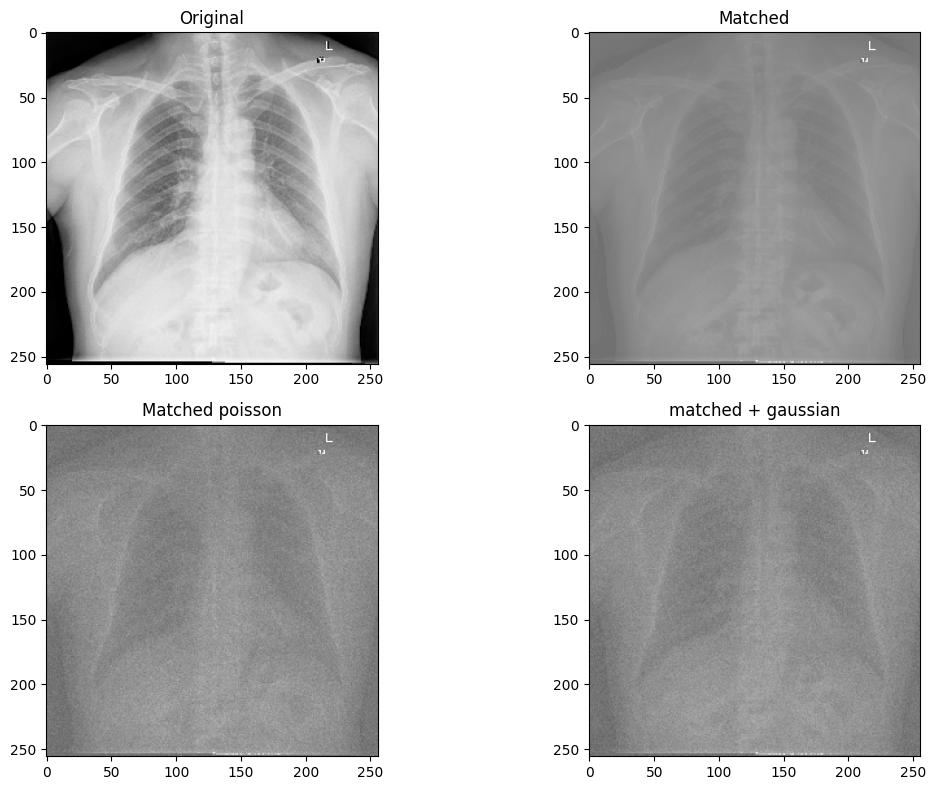

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].imshow(image_original[0], cmap = 'gray', vmin = 0, vmax = 255)  
axs[0, 0].set_title('Original')

axs[0, 1].imshow(matched[0], cmap = 'gray', vmin = 0, vmax = 255)  
axs[0, 1].set_title('Matched')

axs[1, 0].imshow(matched_poisson[0], cmap = 'gray', vmin = 0, vmax = 255) 
axs[1, 0].set_title('Matched poisson')

axs[1, 1].imshow(matched_gaussian[0], cmap = 'gray', vmin = 0, vmax = 255) 
axs[1, 1].set_title('matched + gaussian')

plt.tight_layout()

plt.show()

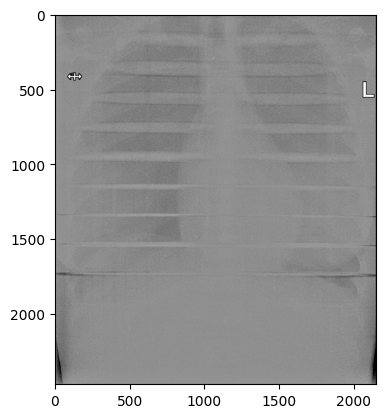

In [8]:
plt.imshow(reference, cmap ='gray', vmin = 0, vmax = 255)

In [28]:
reference_dir = r'/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom'
file_paths = [os.path.join(dirpath,f) for (dirpath, dirnames, filenames) in os.walk(reference_dir) for f in filenames] 
file_paths

['/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom/3330.dcm',
 '/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom/4120.dcm',
 '/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom/3710.dcm',
 '/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom/1550.dcm',
 '/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom/1150.dcm',
 '/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom/1390.dcm',
 '/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom/2120.dcm',
 '/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom/650.dcm',
 '/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom/1250.dcm',
 '/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom/710.dcm',
 '/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom/1760.dcm',
 '/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom/1050.dcm',
 '/home/alex/Documents/new try/Data/losw-dose-simulation/Phantom/950.dcm',
 '/home/alex/Do

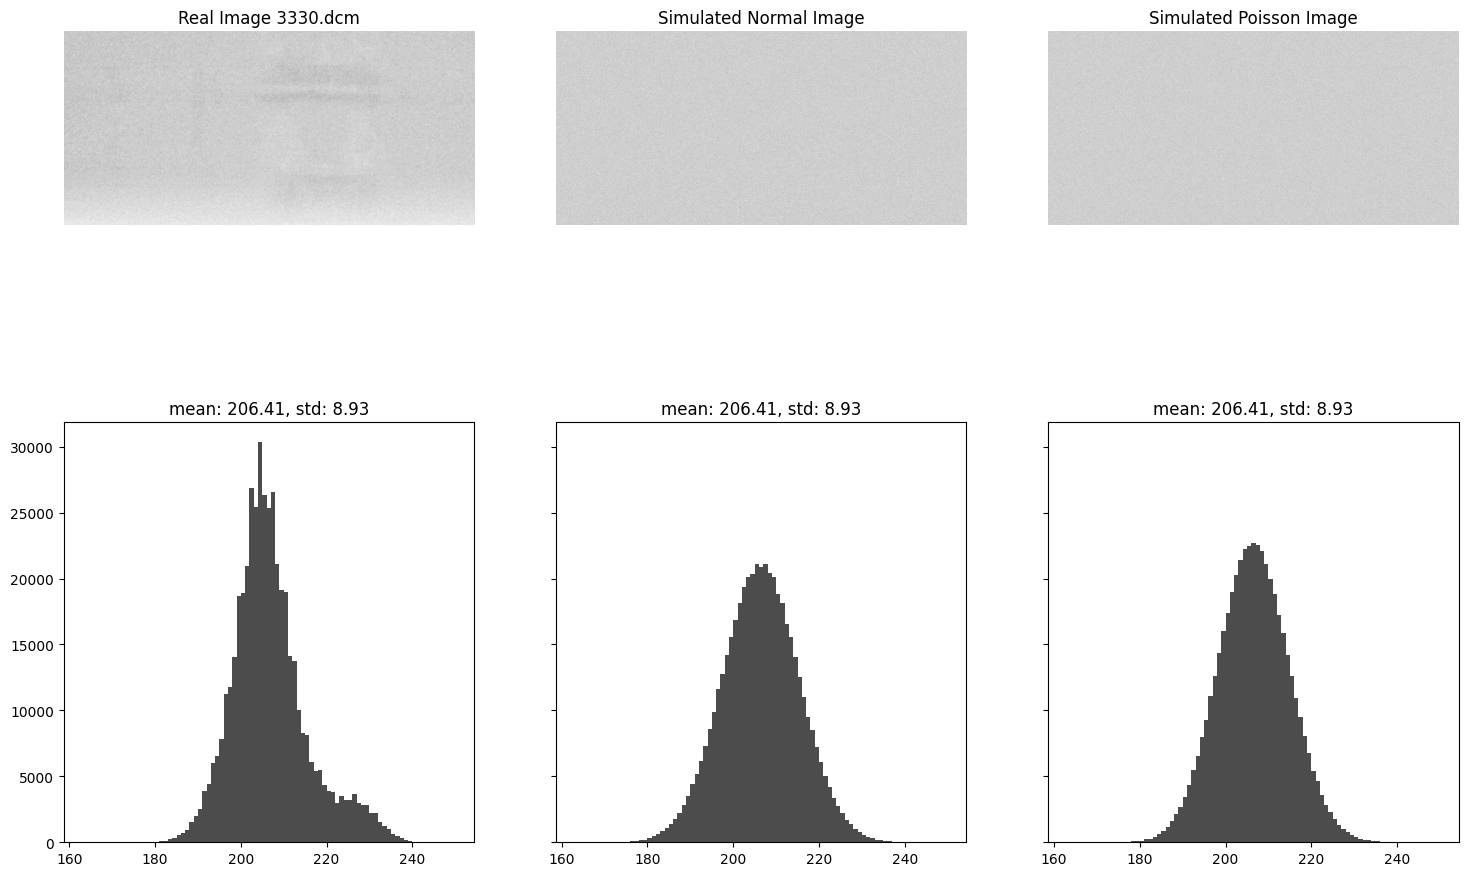

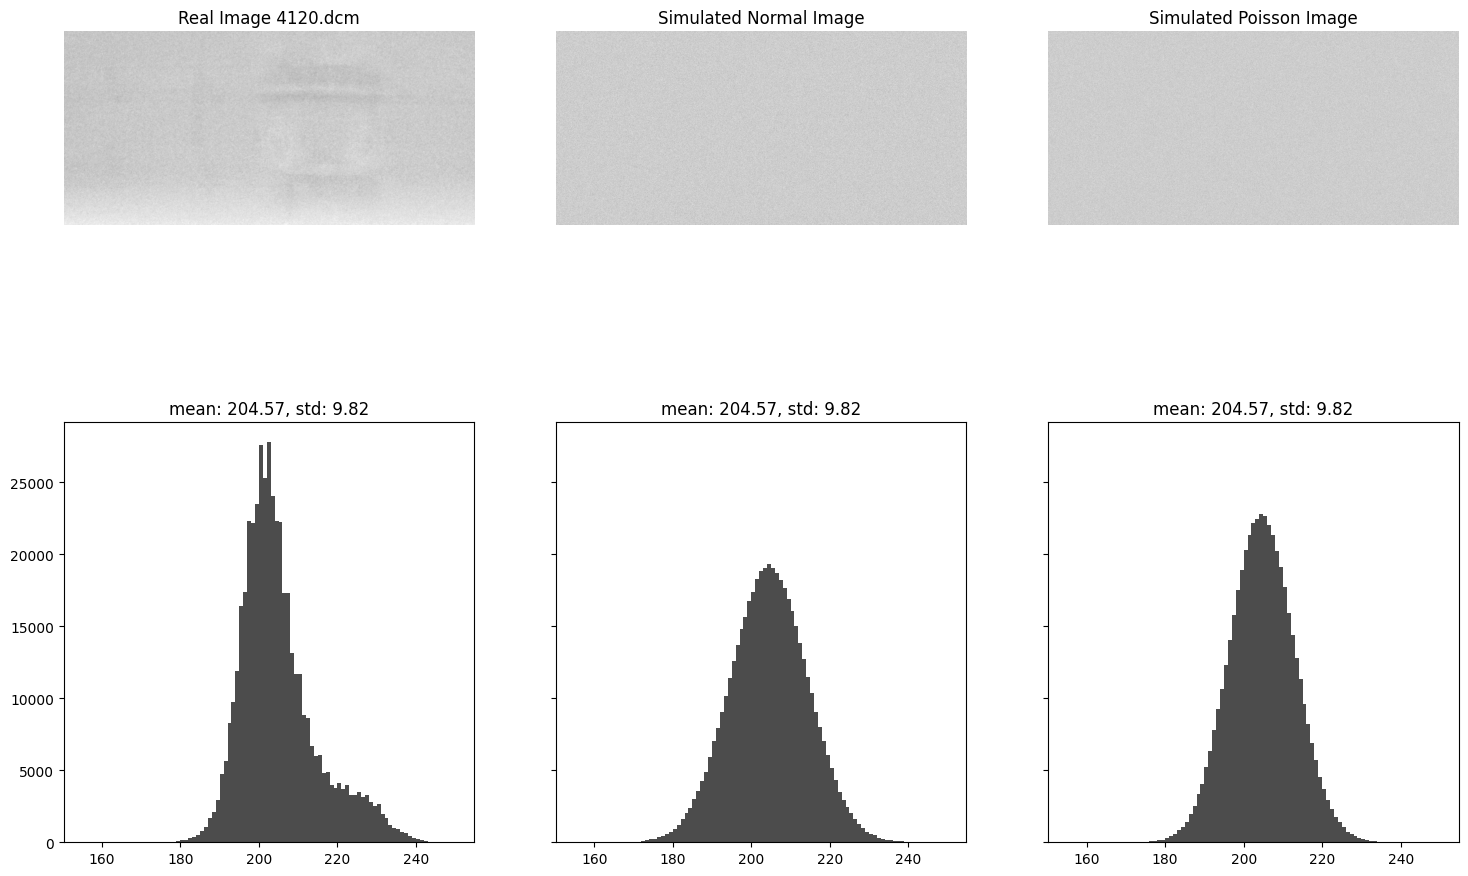

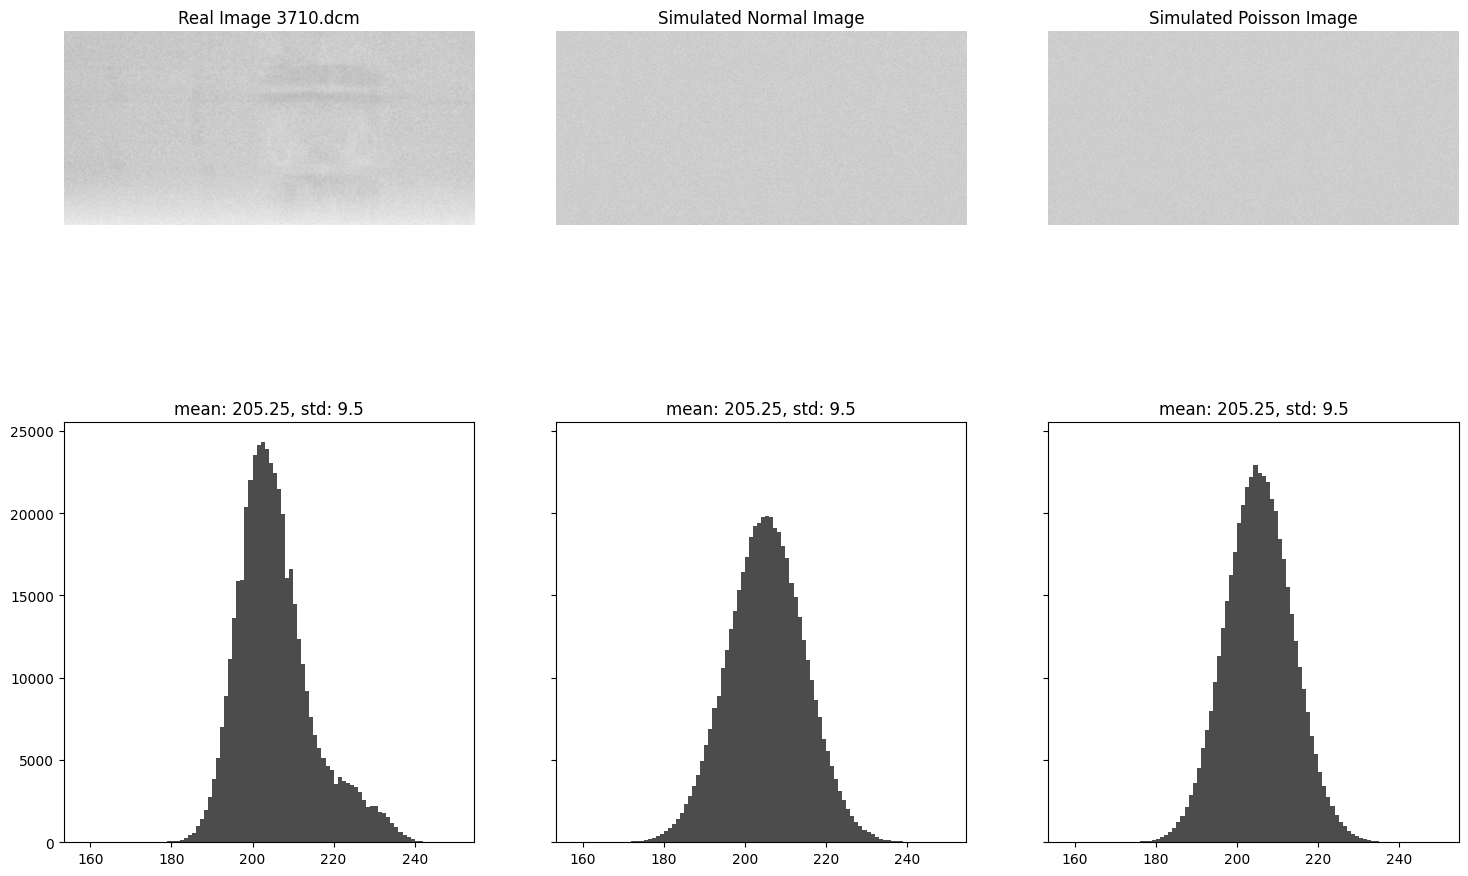

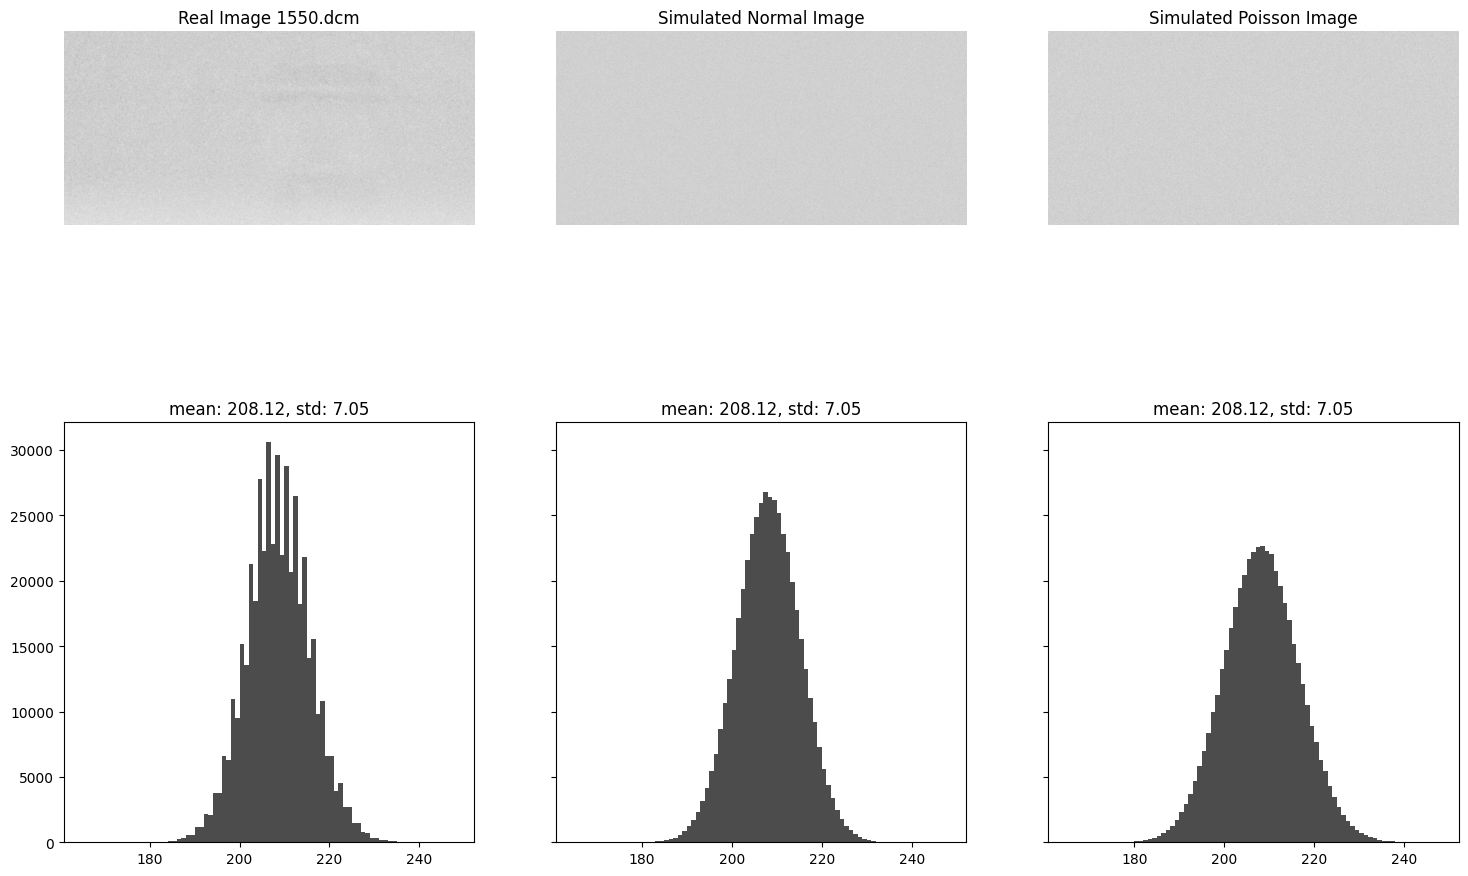

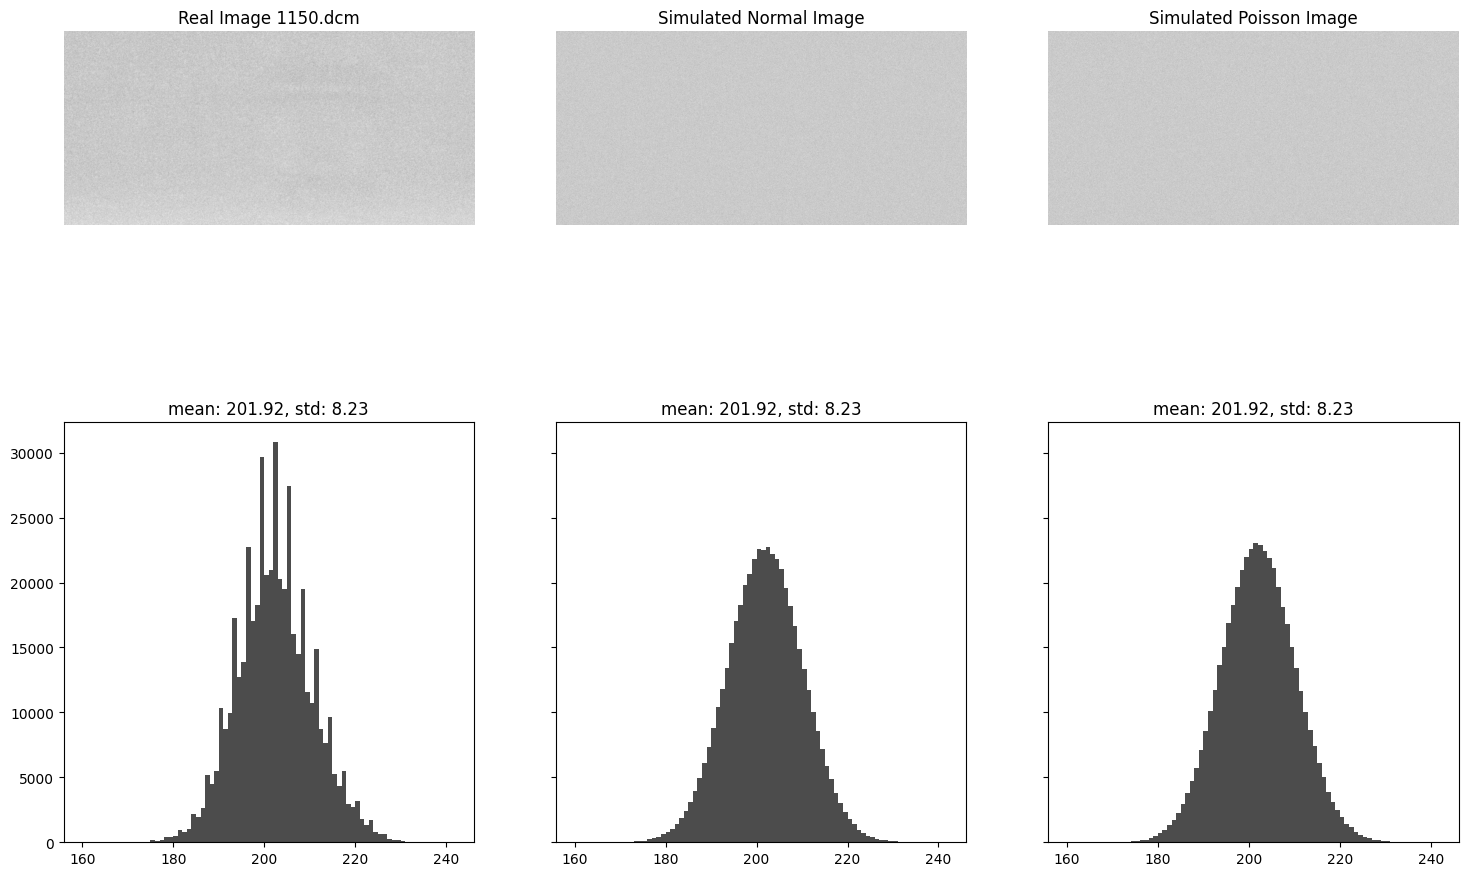

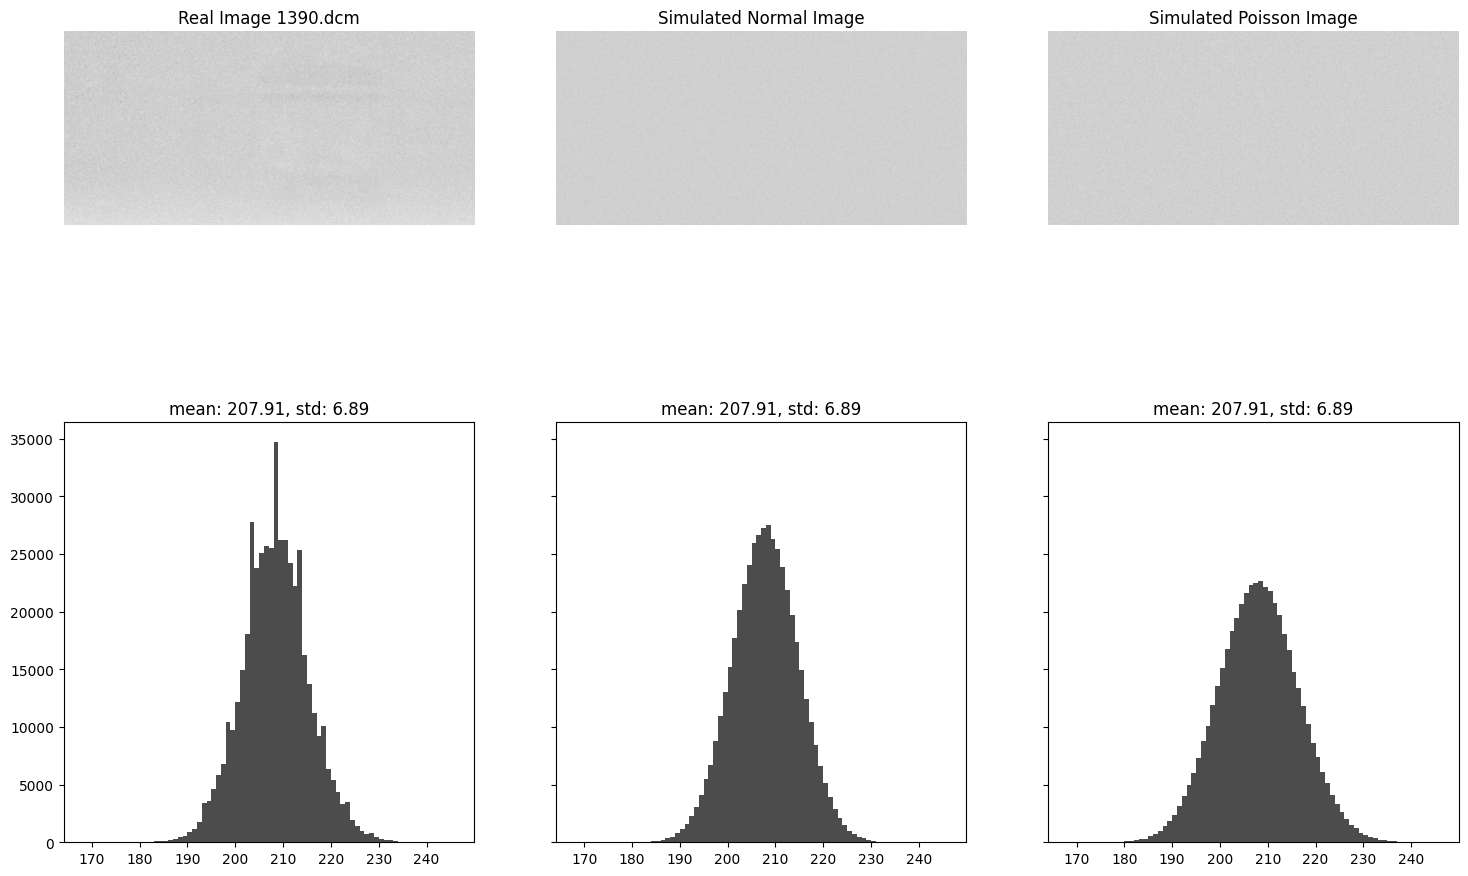

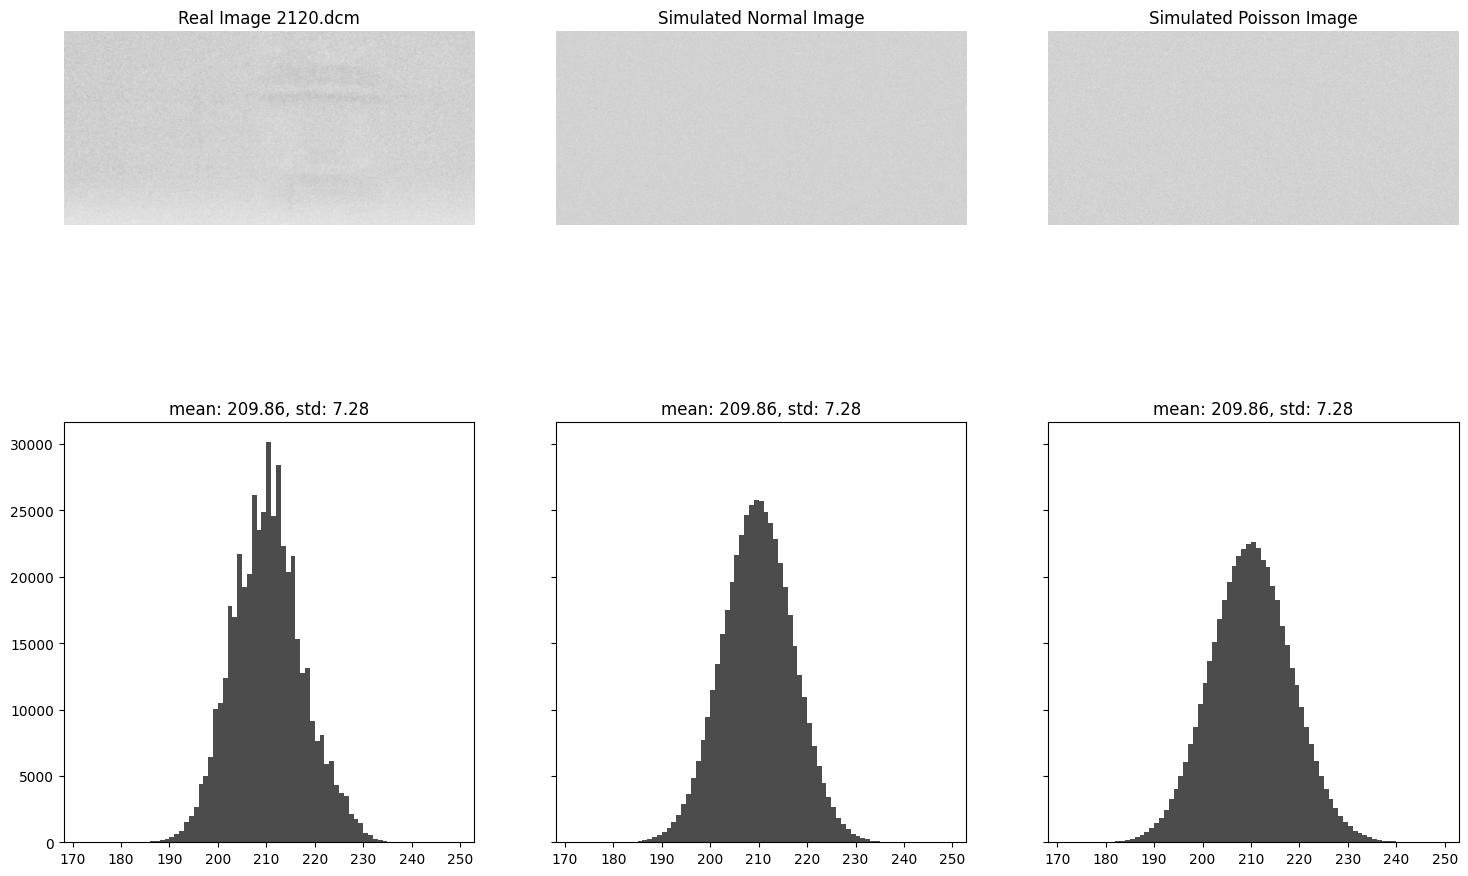

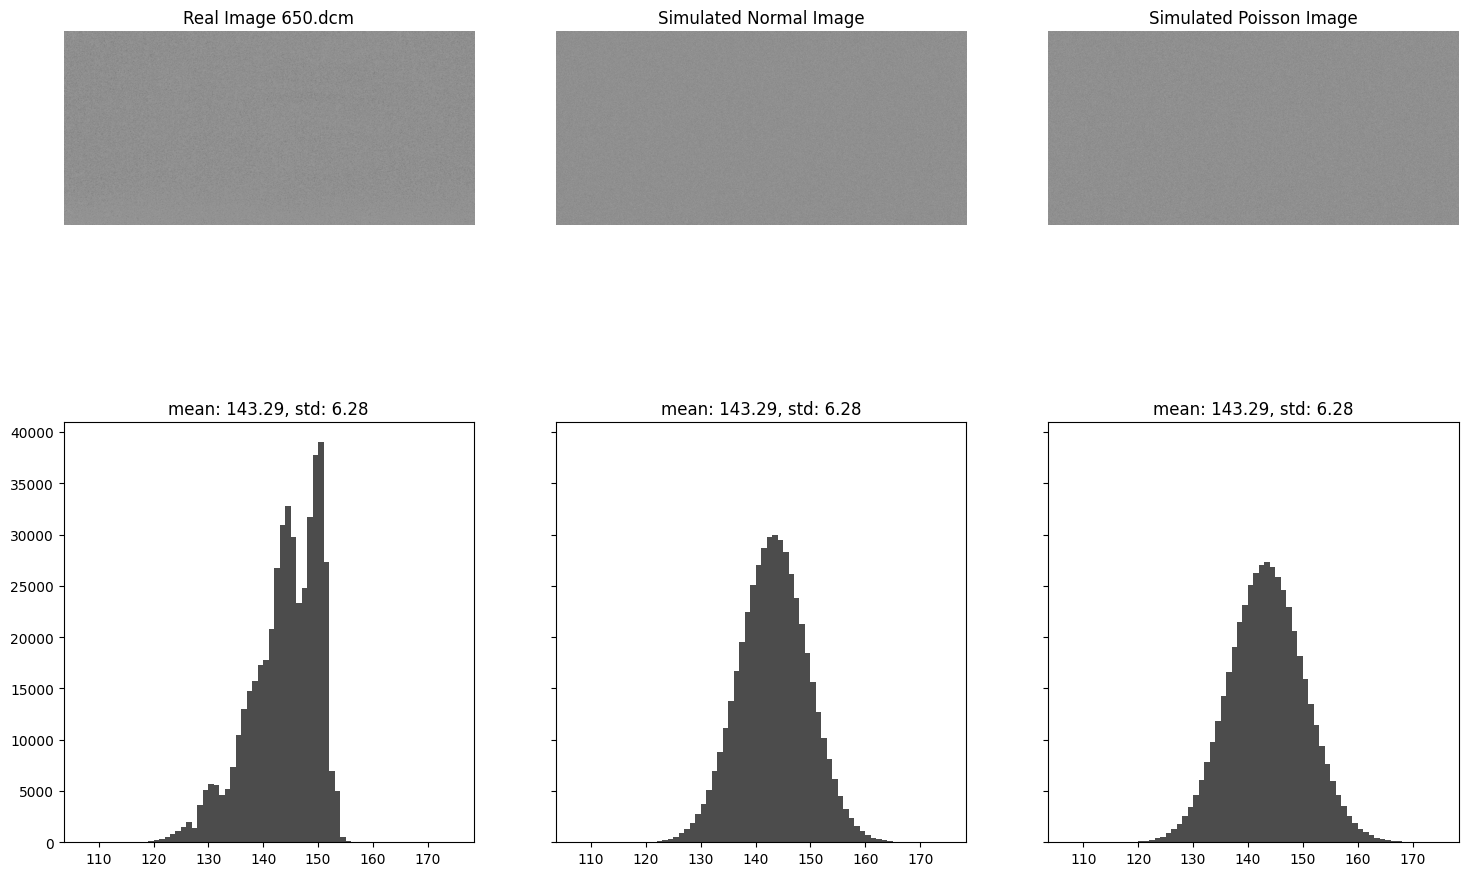

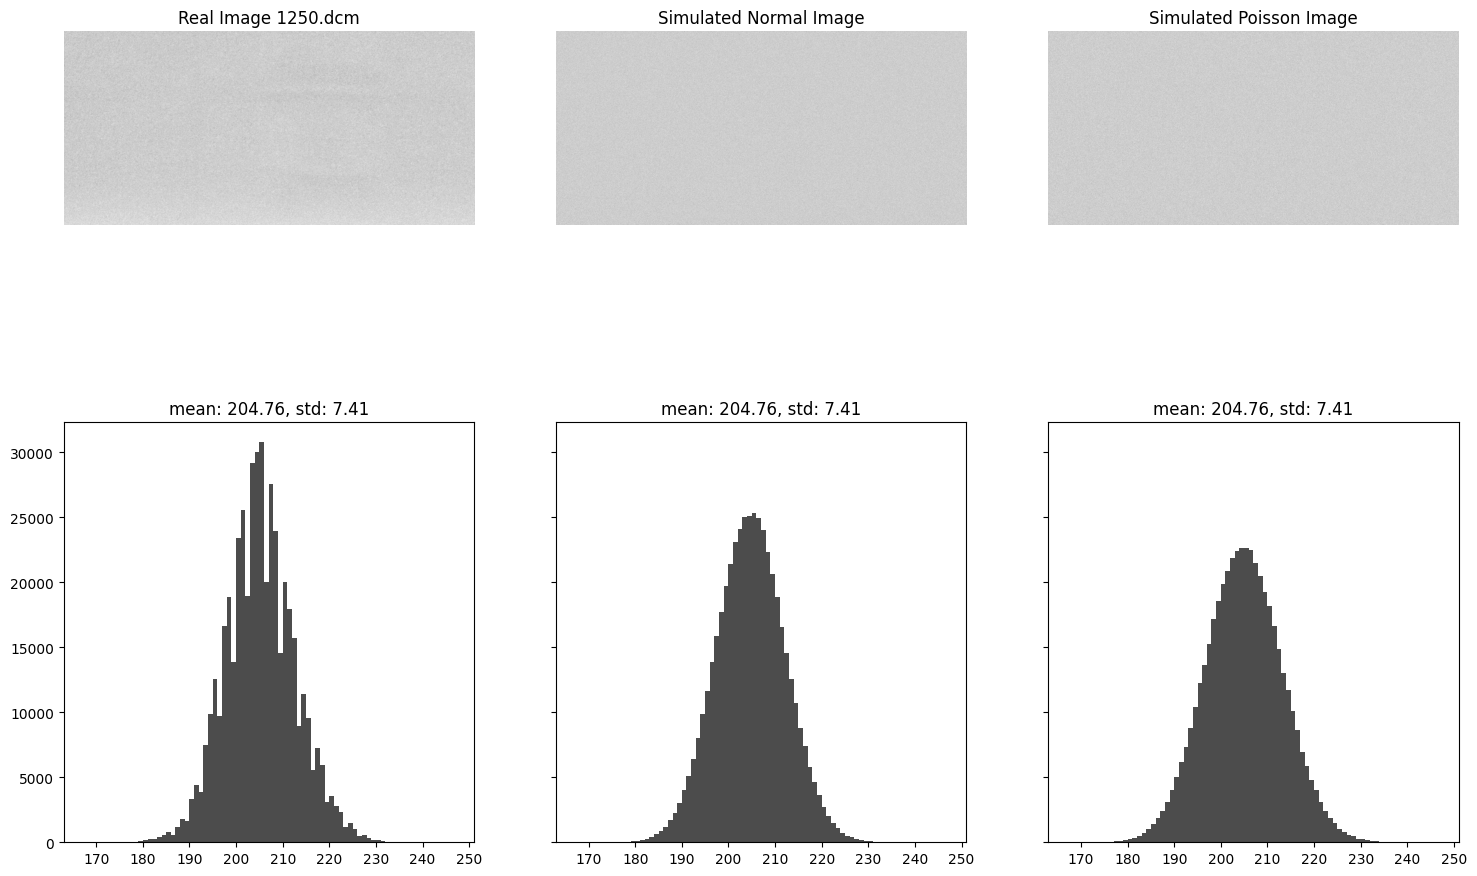

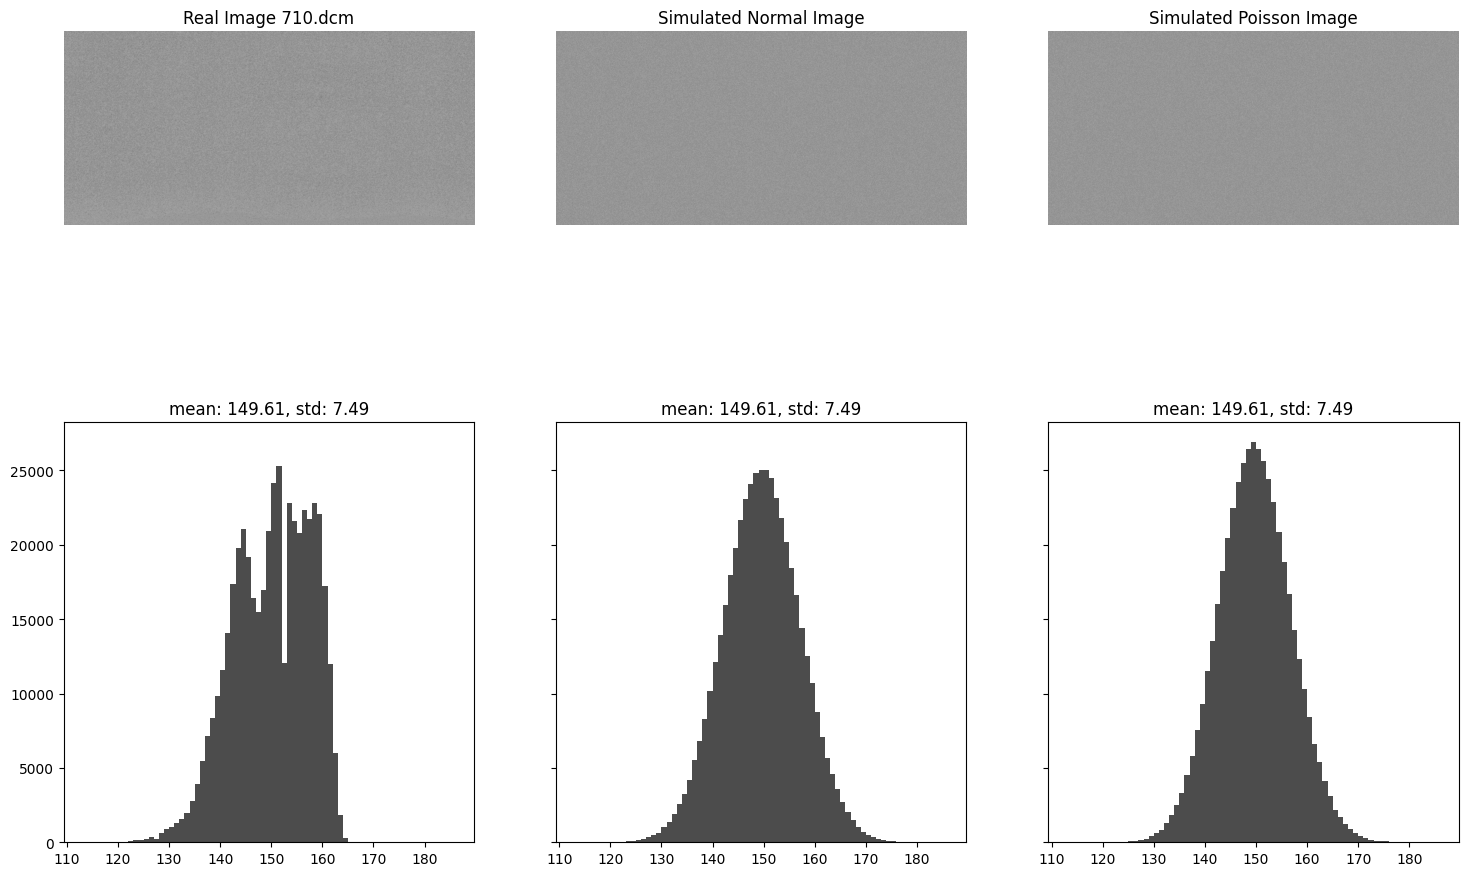

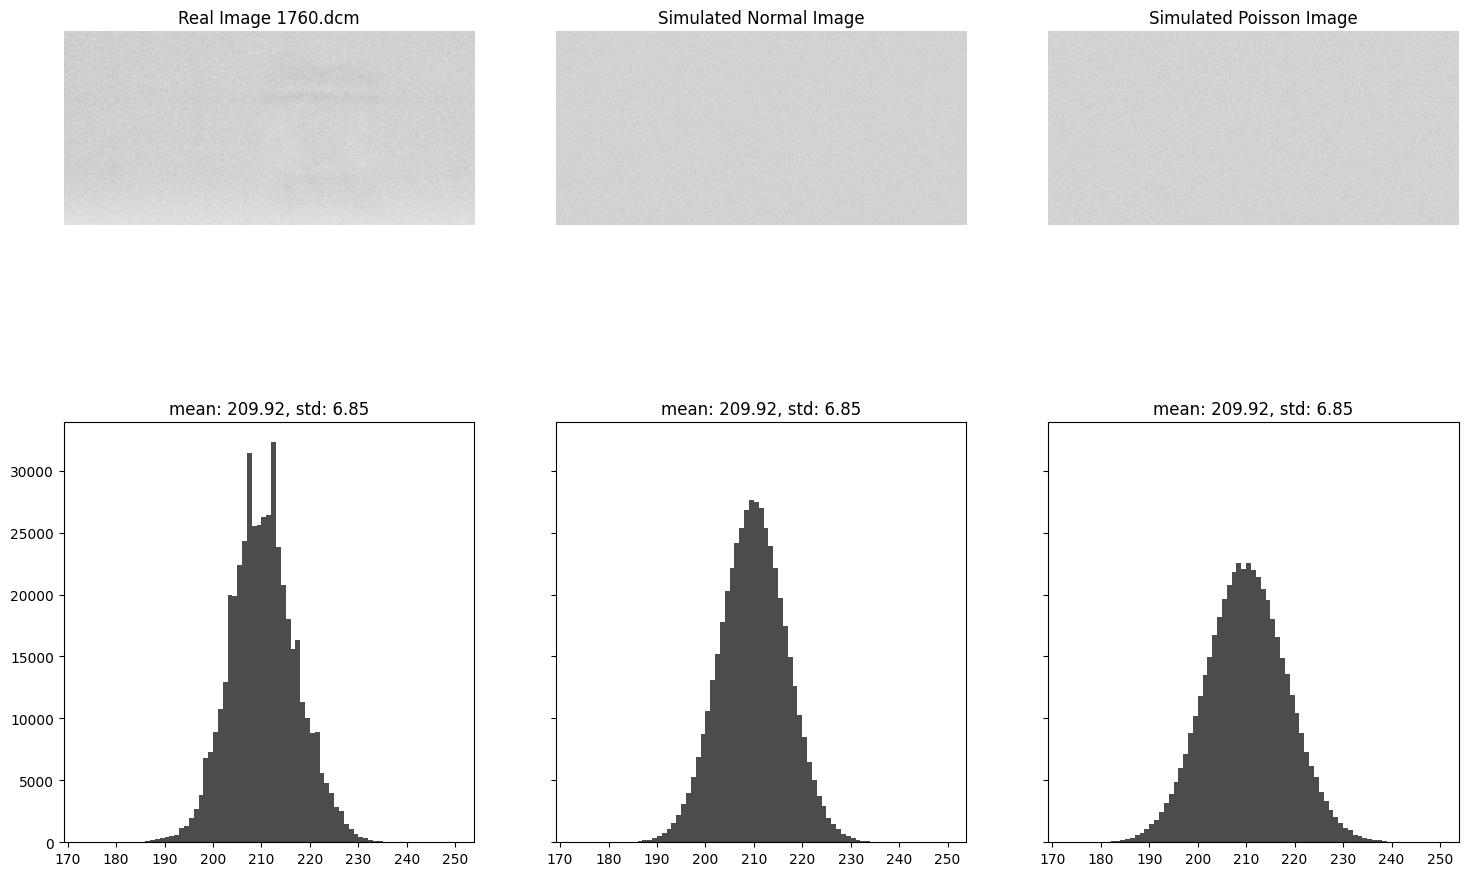

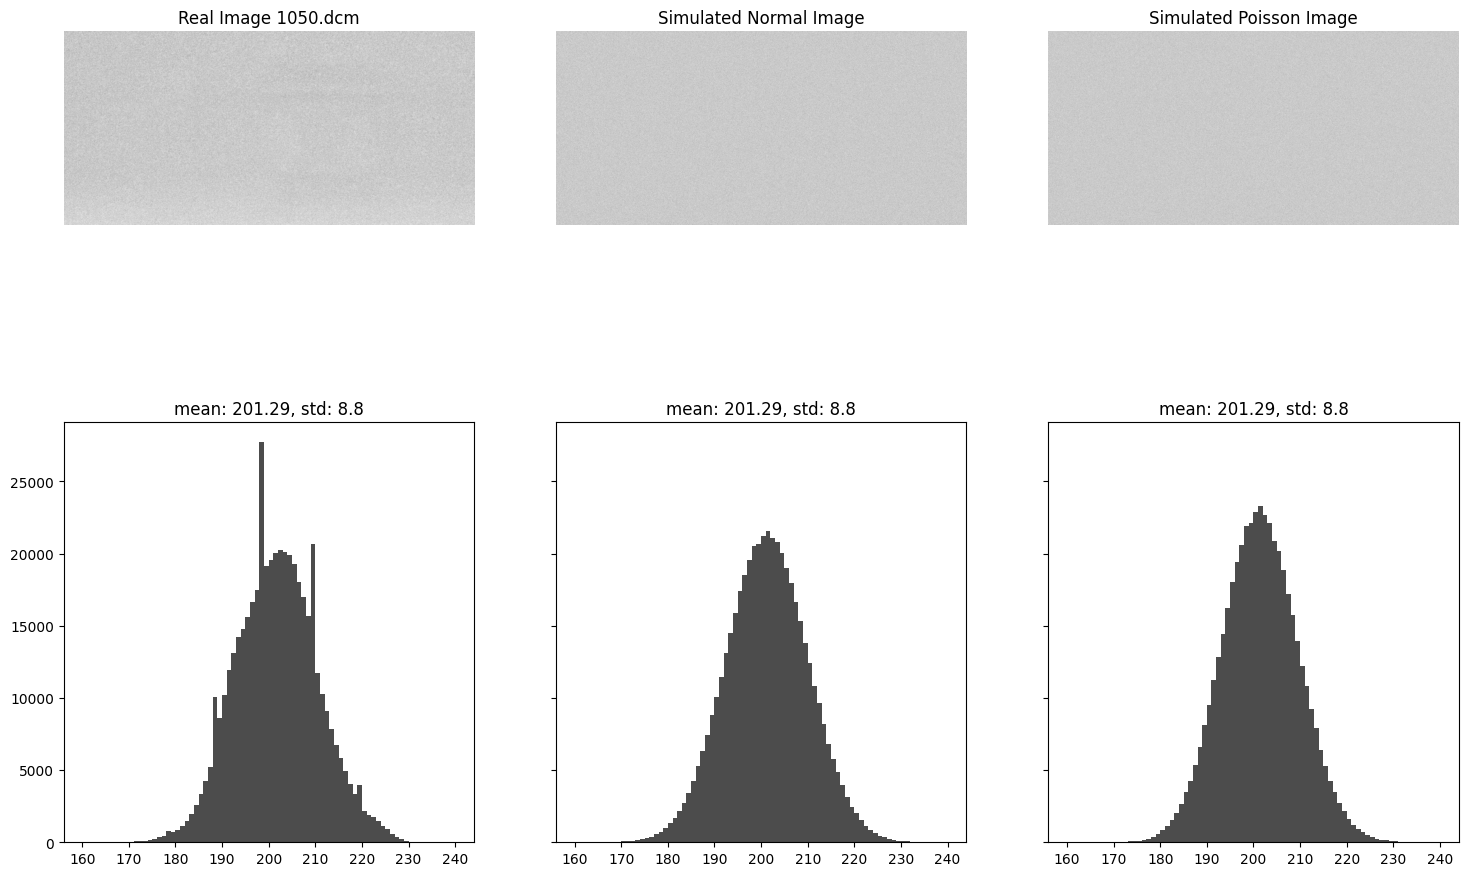

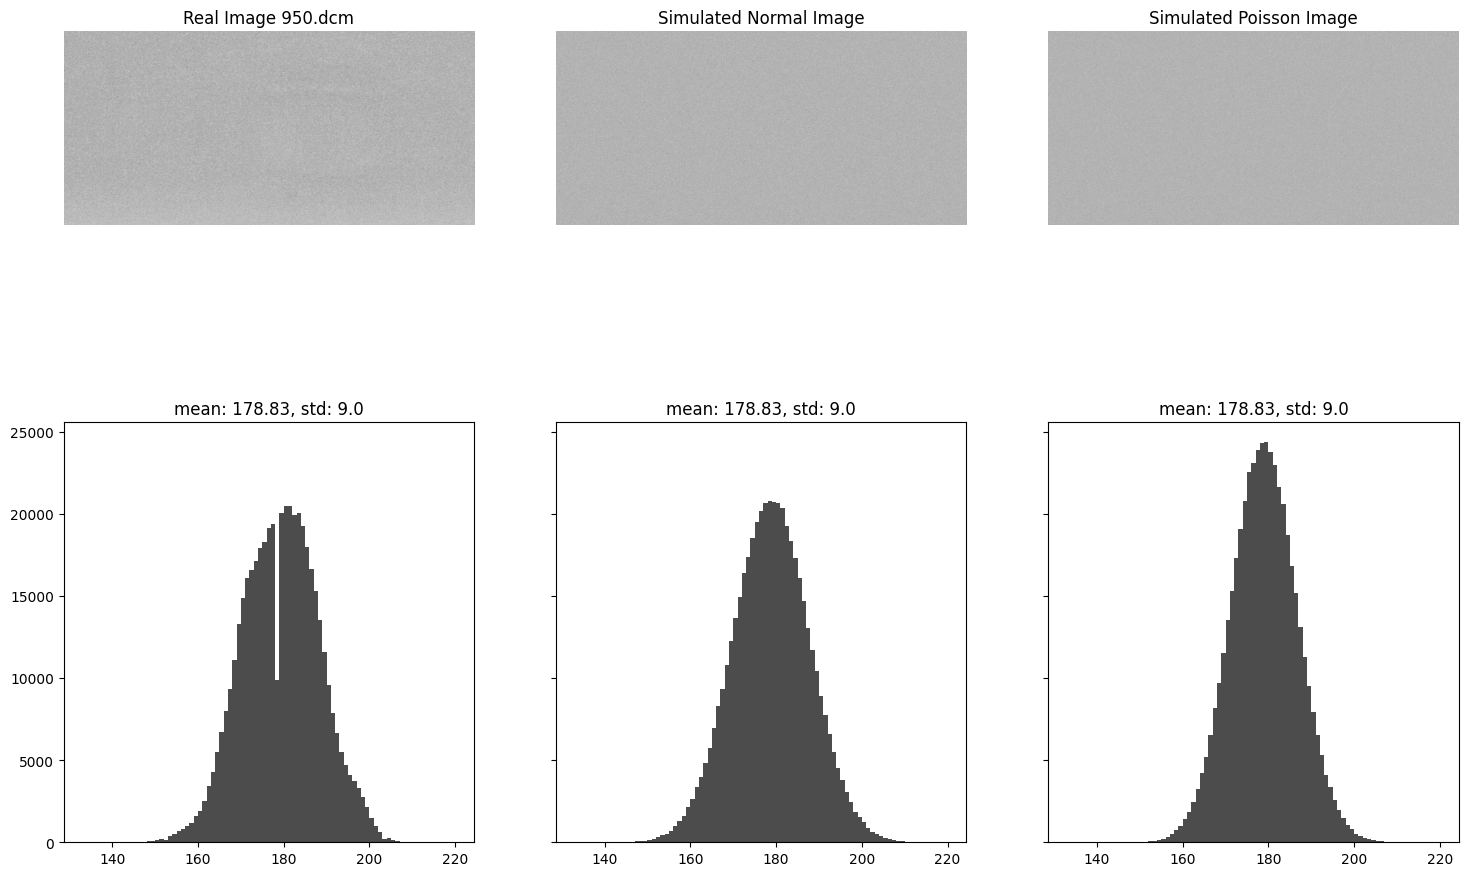

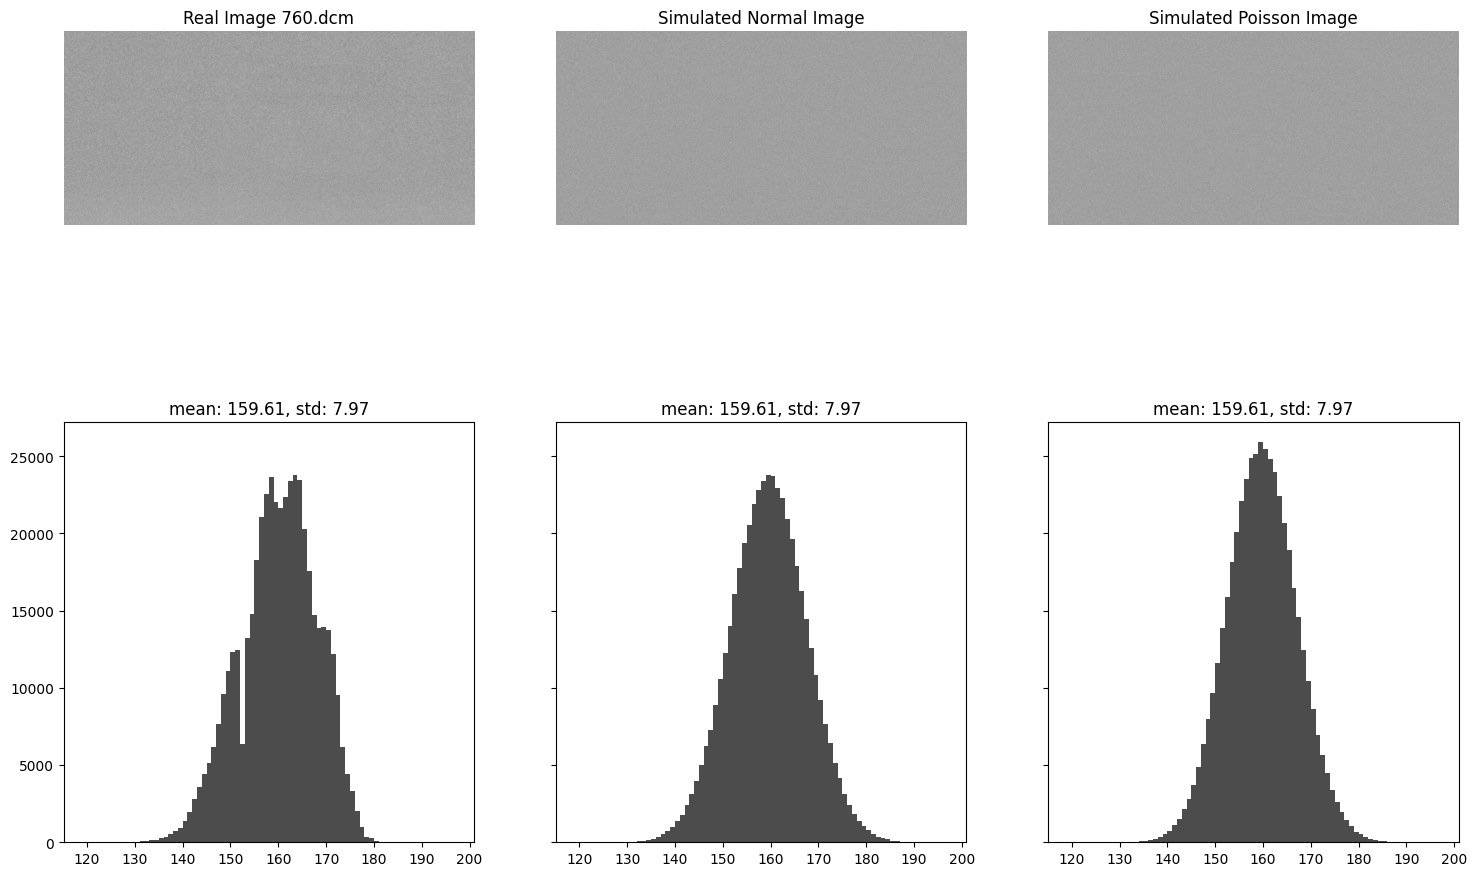

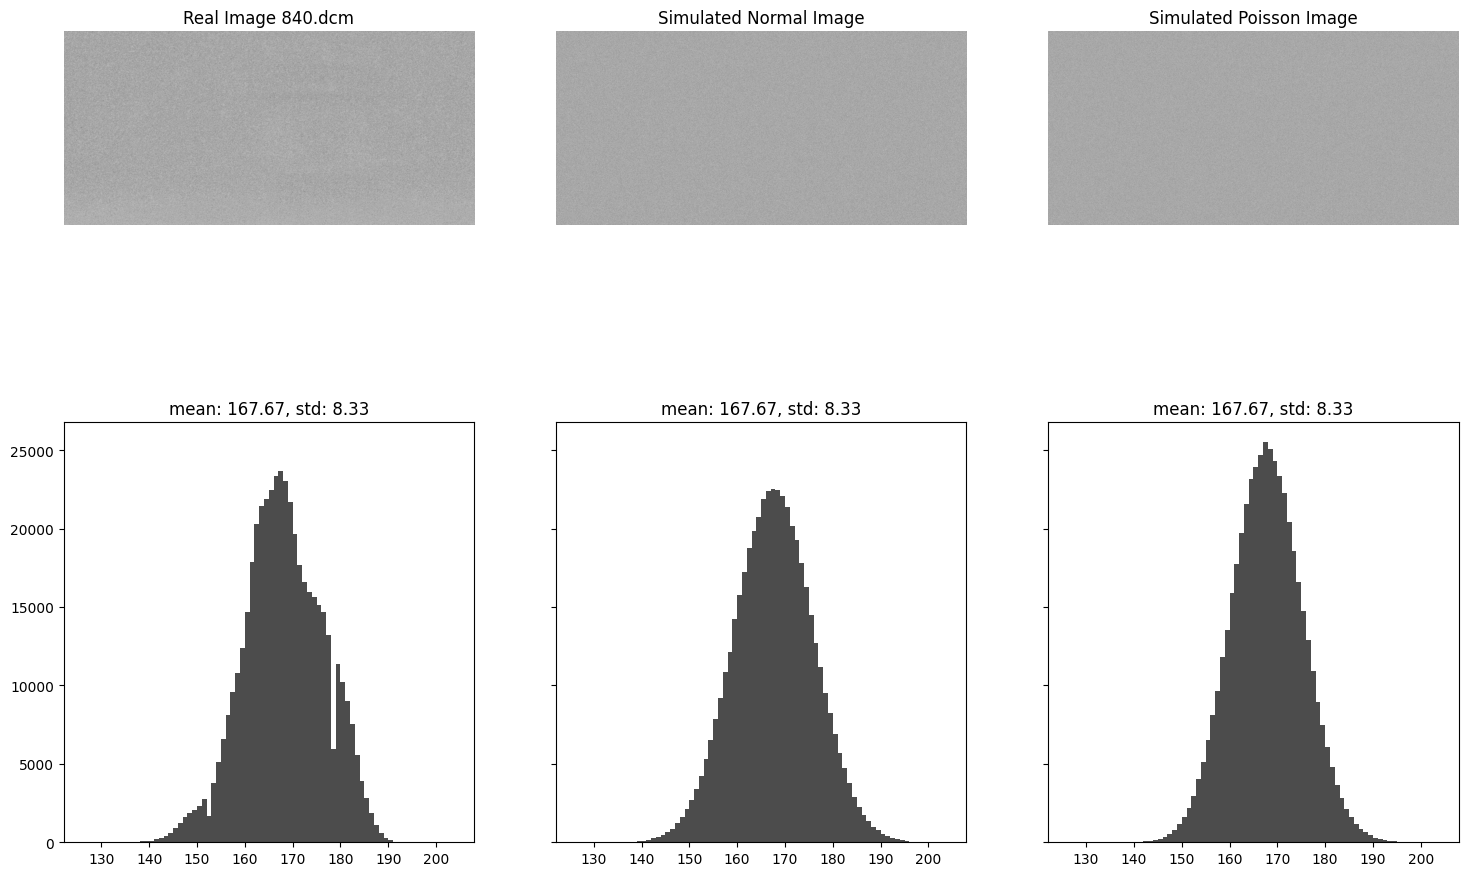

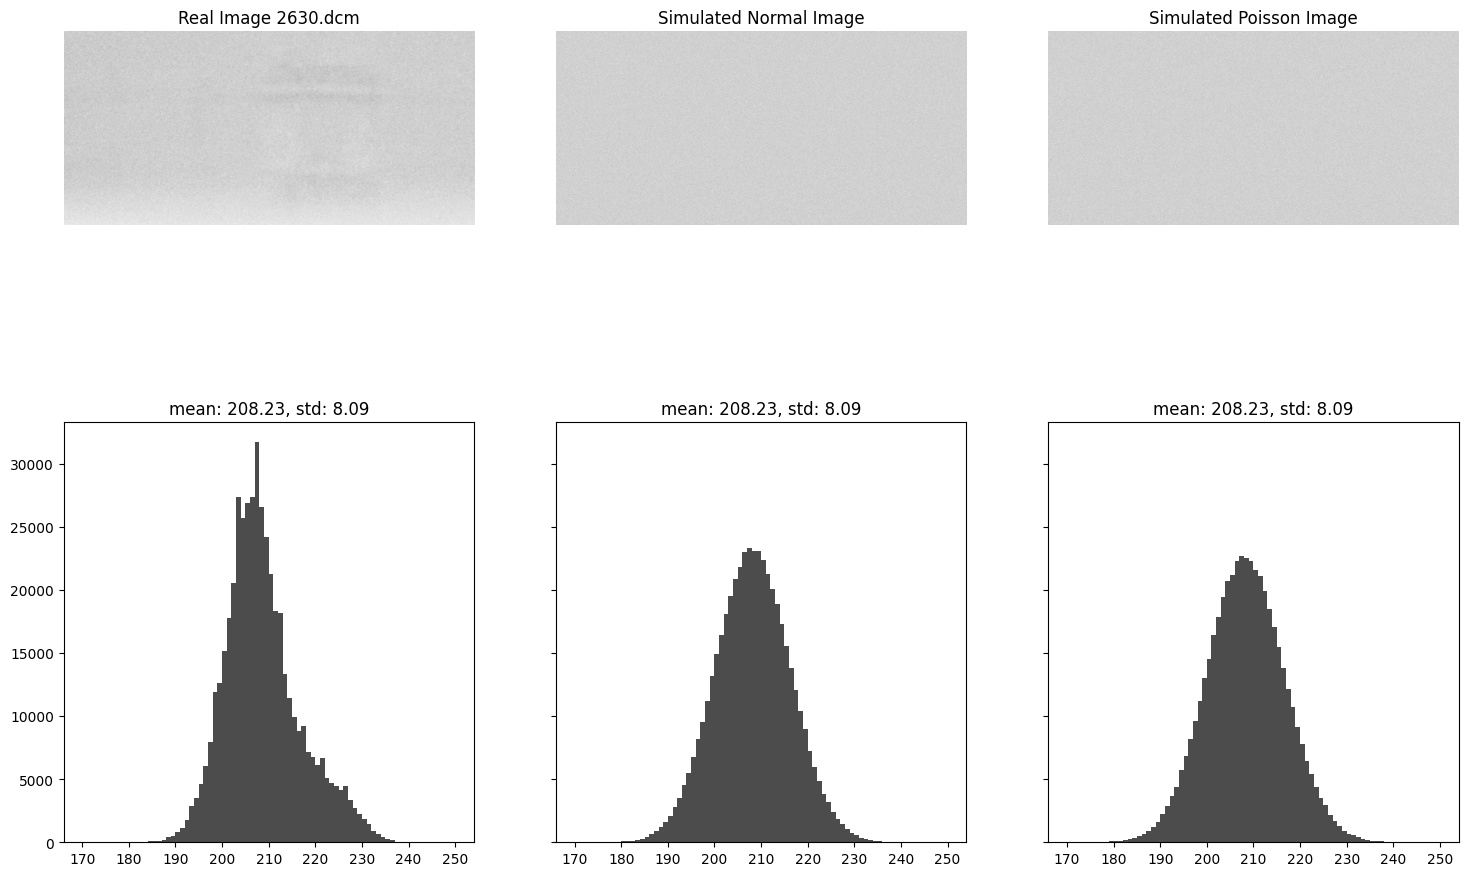

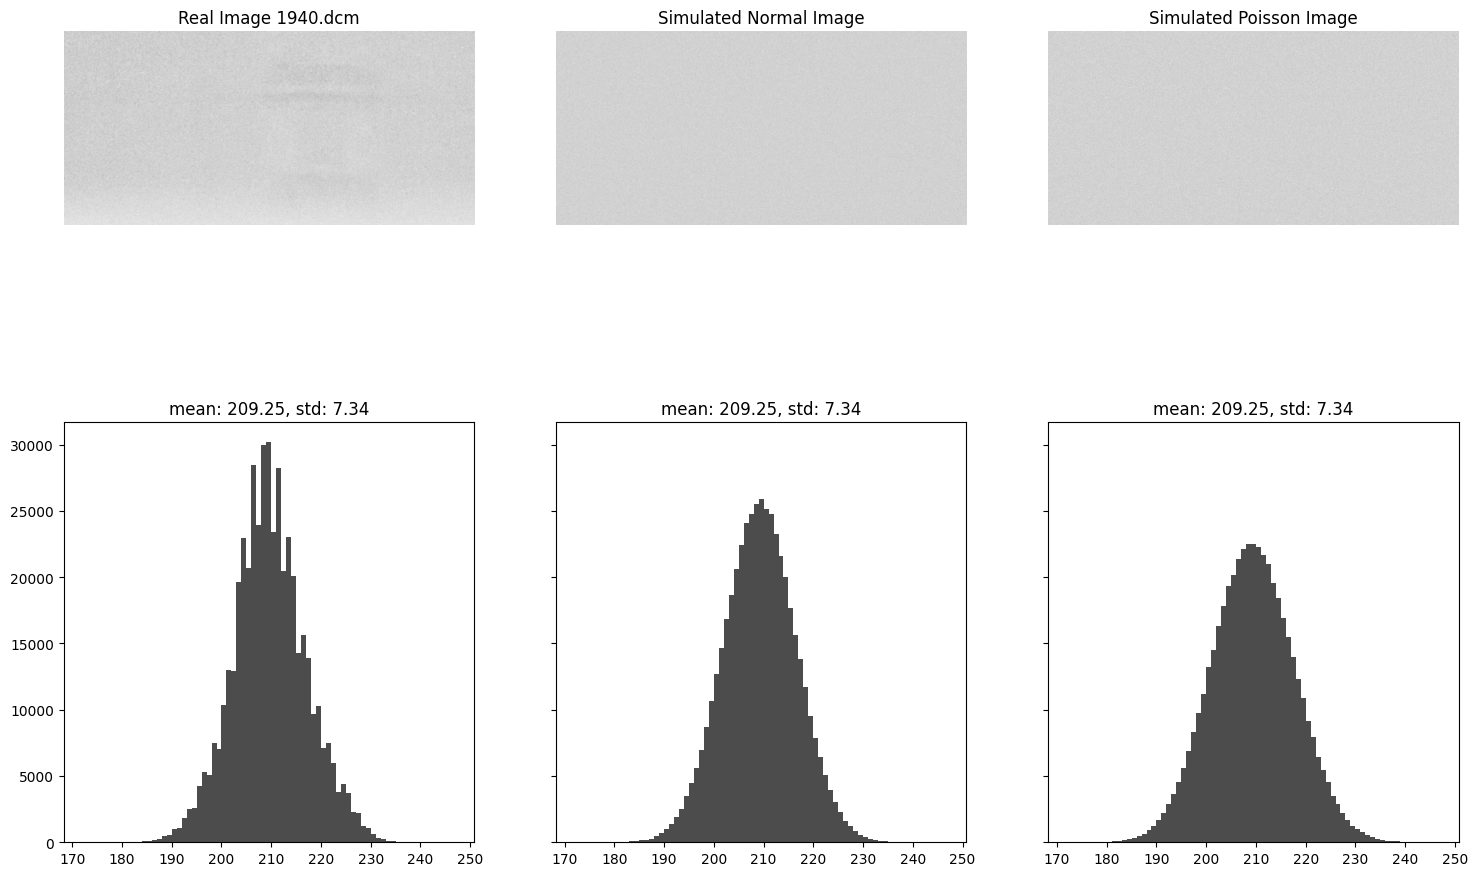

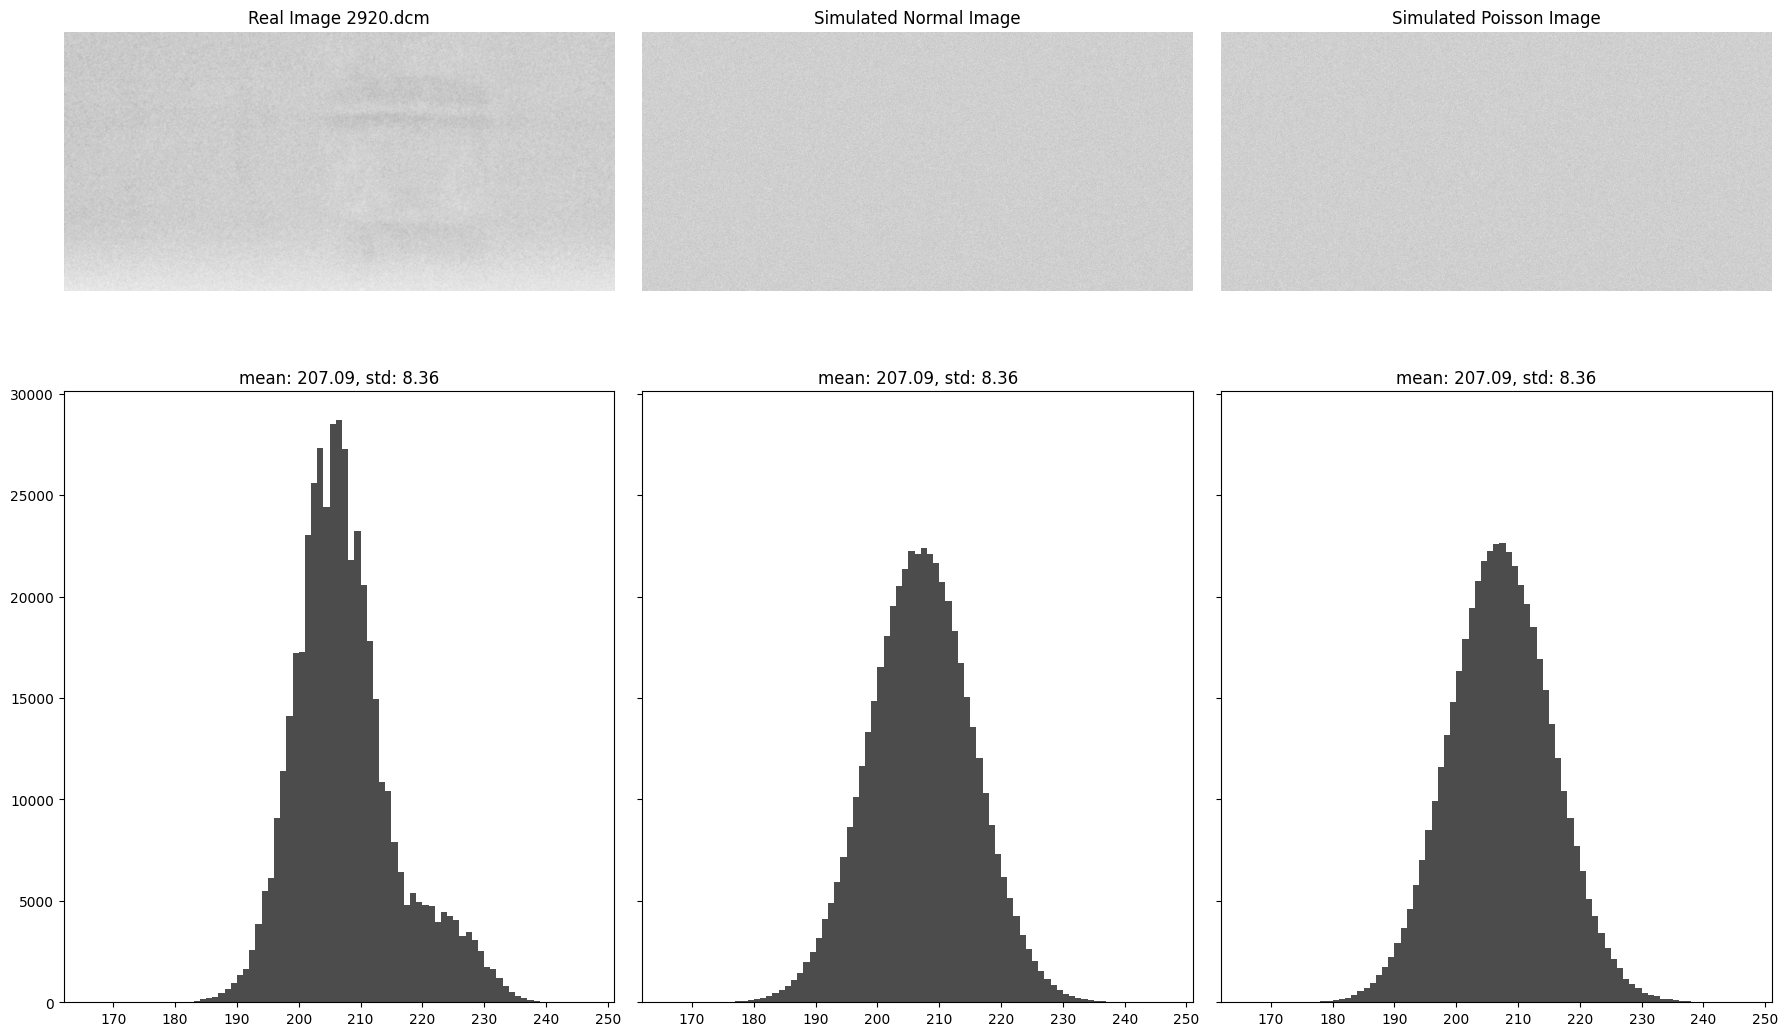

In [30]:
for path in file_paths:
    reference, _, _, _ = get_image(path)
    cropped = reference[2000:, 500:1500]
    
    shape = cropped.shape
    mean = round(cropped.mean(), 2)
    std = round(cropped.std(), 2)
    #simulated normal
    simulated = np.random.normal(loc=mean, scale=std, size=shape) 
    simulated = np.clip(simulated, 0, 255).astype(np.uint8)

    #simulated poisson
    alpha = 3
    simulated_poisson = np.random.poisson((alpha*mean)*np.ones(shape))/alpha
    simulated_poisson = np.clip(simulated_poisson, 0, 255).astype(np.uint8)

    global_min = min(np.min(cropped), np.min(simulated), np.min(simulated_poisson))
    global_max = max(np.max(cropped), np.max(simulated) , np.max(simulated_poisson))

    # Define the range for the histograms based on the global min and max
    hist_range = (global_min, global_max)
    bins = global_max - global_min

    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey='row')
    axes[0, 0].imshow(cropped, cmap='gray', vmin = 0, vmax = 255)
    axes[0, 0].set_title(f'Real Image {path.split("/")[-1]}')
    axes[0, 0].axis('off')
    
    # Real Image Histogram
    axes[1, 0].hist(cropped.ravel(), bins = bins, range = hist_range, color='black', alpha=0.7)
    axes[1, 0].set_title(f'mean: {mean}, std: {std}')
    
    # Simulated Image
    axes[0, 1].imshow(simulated, cmap='gray', vmin = 0, vmax = 255)
    axes[0, 1].set_title(f'Simulated Normal Image')
    axes[0, 1].axis('off')
    
    # Simulated Image Histogram
    axes[1, 1].hist(simulated.ravel(), bins = bins, range = hist_range, color='black', alpha=0.7)
    axes[1, 1].set_title(f'mean: {mean}, std: {std}')

     # Simulated poisson Image
    axes[0, 2].imshow(simulated_poisson, cmap='gray', vmin = 0, vmax = 255)
    axes[0, 2].set_title(f'Simulated Poisson Image')
    axes[0, 2].axis('off')
    
    # Simulated Image Histogram
    axes[1, 2].hist(simulated_poisson.ravel(), bins = bins, range = hist_range, color='black', alpha=0.7)
    axes[1, 2].set_title(f'mean: {mean}, std: {std}')

# Adjust layout
plt.tight_layout()
plt.show()